# Game Analysis
Here I calculate some statistics about all the games I have played on chess.com (up to 13/06/2021).

## TOC
 - [Read Data](#Read-Data)
 - [Overview of Data](#Overview-of-Data)
 - [Pre-Processing](#Pre-Processing)
 - [Explore Data](#Explore-Data)
  - [Overall Win Rates](#Overall-Win-Rates)
  - [Cummulative Win Rate](#Cummulative-Win-Rate)
  - [Rolling Win Rate](#Rolling-Win-Rate)
  - [Outcomes](#Outcomes)

In [1]:
import json

import numpy as np
import pandas as pd
import seaborn as sns

import Fetcher as F
import Reader as R

In [2]:
pd.options.display.max_columns = None

In [3]:
exp_white_win_rate=(.52,.56)
exp_black_win_rate=(.44,.48)

## Read Data
`games.csv` was obtained using `Fetcher.fetch_every_game`.

In [4]:
df=F.__read_csv("data/games.csv")
df=df.rename(columns={"time_control":"time_limit"})

## Overview of Data

In [5]:
df.shape

(909, 10)

The dataset contains 10 fields for 896 games. However, this data has not been fully processed and many of the fields contain more than once piece of data.

In [6]:
# View of data
df.loc[0,:]

url                  https://www.chess.com/game/live/6009142163
pgn           [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...
time_limit                                                  600
end_time                                             1608417059
rated                                                      True
fen           rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...
time_class                                                rapid
rules                                                     chess
white         {'rating': 1362, 'result': 'win', '@id': 'http...
black         {'rating': 1038, 'result': 'abandoned', '@id':...
Name: 0, dtype: object

In [7]:
# remove non-"rapid" games (this is <10 games)
df = df.drop(df[df["time_class"]!="rapid"].index)

## Pre-Processing
Mainly extracting data from fields which hold multiple pieces of data (`pgn`,`fen`,`white`,`black`)

In [8]:
def process_colour_data(strs:pd.Series,colour:str) -> df:
    dicts=df.loc[:,colour].apply(lambda x:json.loads(x.replace("'","\"")))
    
    new_df=pd.DataFrame()
    new_df[colour+"_rating"]=dicts.apply(lambda x:x["rating"])
    new_df[colour+"_username"]=dicts.apply(lambda x:x["username"])
    new_df[colour+"_result"]=dicts.apply(lambda x:x["result"])
    return new_df

In [9]:
# extract info about players
df=df.merge(process_colour_data(df.loc[:,"white"],"white"), left_index=True, right_index=True)
df=df.merge(process_colour_data(df.loc[:,"black"],"black"), left_index=True, right_index=True)

In [10]:
# colour
df["my_colour"]=df["white_username"].apply(lambda x: "white" if (x=="DomHutchinson") else "black")
df["opponent_colour"]=df["white_username"].apply(lambda x: "white" if (x!="DomHutchinson") else "black")

In [11]:
# ratings
df["my_rating"]=df.apply(lambda x:x["white_rating"] if (x["white_username"]=="DomHutchinson") else x["black_rating"],axis=1)
df["opponent_rating"]=df.apply(lambda x:x["white_rating"] if (x["white_username"]!="DomHutchinson") else x["black_rating"],axis=1)

In [12]:
# my result
my_result_func=lambda x:x["white_result"] if x["my_colour"]=="white" else x["black_result"]
df["my_result"]=df[["my_colour","white_result","black_result"]].apply(my_result_func,axis=1)

In [13]:
# opponent result
opponent_result_func=lambda x:x["white_result"] if x["opponent_colour"]=="white" else x["black_result"]
df["opponent_result"]=df[["opponent_colour","white_result","black_result"]].apply(opponent_result_func,axis=1)

In [14]:
# my outcome (win,draw,loss rather than detail)
is_win=lambda x:x in ["win"]
is_draw=lambda x:x in ["agreed","repetition","stalemate","insufficient","50move","timevsinsufficient"]
is_loss=lambda x:x in ["checkmated","timeout","resigned","lose","abandoned"]
map_result=lambda x:"win" if is_win(x) else ("draw" if is_draw(x) else "loss")

df["my_outcome"]=df["my_result"].apply(map_result)

In [15]:
df.head(5)

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,white_rating,white_username,white_result,black_rating,black_username,black_result,my_colour,opponent_colour,my_rating,opponent_rating,my_result,opponent_result,my_outcome
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",1362,DomHutchinson,win,1038,GenevievePlenty,abandoned,white,black,1362,1038,win,abandoned,win
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",1227,DomHutchinson,resigned,1390,sri3421,win,white,black,1227,1390,resigned,win,loss
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",1383,ChessGodBossom,win,1142,DomHutchinson,resigned,black,white,1142,1383,resigned,win,loss
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",1032,DomHutchinson,resigned,1081,ElliottSand,win,white,black,1032,1081,resigned,win,loss
5,https://www.chess.com/game/live/6010299471,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608429267,True,r1bqk2r/pppp1ppp/1b6/3QP3/1n6/2N2N2/P4PPP/R1B1...,rapid,chess,"{'rating': 996, 'result': 'resigned', '@id': '...","{'rating': 1099, 'result': 'win', '@id': 'http...",996,JanoGhost,resigned,1099,DomHutchinson,win,black,white,1099,996,win,resigned,win


In [16]:
# identify winner's colour and reason for outcome
df["winner_colour"]=df.apply(lambda x:"white" if (x["white_result"]=="win") else ("black" if x["black_result"]=="win" else "draw"),axis=1)
df["winner_reason"]=df.apply(lambda x:x["black_result"] if (x["white_result"]=="win") else (x["white_result"] if x["black_result"]=="win" else x["white_result"]),axis=1)

In [17]:
df.head()

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,white_rating,white_username,white_result,black_rating,black_username,black_result,my_colour,opponent_colour,my_rating,opponent_rating,my_result,opponent_result,my_outcome,winner_colour,winner_reason
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",1362,DomHutchinson,win,1038,GenevievePlenty,abandoned,white,black,1362,1038,win,abandoned,win,white,abandoned
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",1227,DomHutchinson,resigned,1390,sri3421,win,white,black,1227,1390,resigned,win,loss,black,resigned
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",1383,ChessGodBossom,win,1142,DomHutchinson,resigned,black,white,1142,1383,resigned,win,loss,white,resigned
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",1032,DomHutchinson,resigned,1081,ElliottSand,win,white,black,1032,1081,resigned,win,loss,black,resigned
5,https://www.chess.com/game/live/6010299471,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608429267,True,r1bqk2r/pppp1ppp/1b6/3QP3/1n6/2N2N2/P4PPP/R1B1...,rapid,chess,"{'rating': 996, 'result': 'resigned', '@id': '...","{'rating': 1099, 'result': 'win', '@id': 'http...",996,JanoGhost,resigned,1099,DomHutchinson,win,black,white,1099,996,win,resigned,win,black,resigned


In [18]:
def extract_from_pgn(pgn_str) -> pd.Series:
    pgn_data,pgn_movetext=R.parse_pgn(pgn_str)
    moves=R.parse_san_movetext(pgn_movetext)
    
    s=pd.Series()
    s["opening_code"]=pgn_data["ECO"]
    s["start_time"]=pd.to_datetime(pgn_data["UTCDate"]+" "+pgn_data["StartTime"])
    s["finish_time"]=pd.to_datetime(pgn_data["EndDate"]+" "+pgn_data["EndTime"])
    s["num_moves"]=len(moves)
    s["moves_data"]=moves
    
    return s

In [19]:
pgn_data=df.apply(lambda x:extract_from_pgn(x["pgn"]),axis=1)

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [20]:
df=df.merge(pgn_data,left_index=True, right_index=True)

In [58]:
# calculate length of match (remove games with negative time)
seconds_taken=(df["finish_time"]-df["start_time"]).dt.total_seconds()
seconds_taken[seconds_taken<0]=np.NaN
df["match_length"]=seconds_taken

# drop matchs with invalid length (<10 games)
df=df.drop(df[df["match_length"].isna()].index)

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._where(~key, value, inplace=True)


In [22]:
df.head()

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,white_rating,white_username,white_result,black_rating,black_username,black_result,my_colour,opponent_colour,my_rating,opponent_rating,my_result,opponent_result,my_outcome,winner_colour,winner_reason,opening_code,start_time,finish_time,num_moves,moves_data,match_length
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",1362,DomHutchinson,win,1038,GenevievePlenty,abandoned,white,black,1362,1038,win,abandoned,win,white,abandoned,B12,2020-12-19 22:20:55,2020-12-19 22:30:59,15,"[(moves pawn to e4., {'special': False, 'piece...",604.0
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",1227,DomHutchinson,resigned,1390,sri3421,win,white,black,1227,1390,resigned,win,loss,black,resigned,B01,2020-12-20 00:30:45,2020-12-20 00:34:21,24,"[(moves pawn to e4., {'special': False, 'piece...",216.0
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",1383,ChessGodBossom,win,1142,DomHutchinson,resigned,black,white,1142,1383,resigned,win,loss,white,resigned,C44,2020-12-20 01:02:37,2020-12-20 01:21:25,91,"[(moves pawn to e4., {'special': False, 'piece...",1128.0
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",1032,DomHutchinson,resigned,1081,ElliottSand,win,white,black,1032,1081,resigned,win,loss,black,resigned,C20,2020-12-20 01:34:59,2020-12-20 01:48:46,69,"[(moves pawn to e4., {'special': False, 'piece...",827.0
5,https://www.chess.com/game/live/6010299471,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608429267,True,r1bqk2r/pppp1ppp/1b6/3QP3/1n6/2N2N2/P4PPP/R1B1...,rapid,chess,"{'rating': 996, 'result': 'resigned', '@id': '...","{'rating': 1099, 'result': 'win', '@id': 'http...",996,JanoGhost,resigned,1099,DomHutchinson,win,black,white,1099,996,win,resigned,win,black,resigned,C20,2020-12-20 01:51:25,2020-12-20 01:54:27,18,"[(moves pawn to e4., {'special': False, 'piece...",182.0


In [23]:
df["time_class"].value_counts()

rapid    906
Name: time_class, dtype: int64

# Explore Data

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,6]

# Overall Win Rates
I completely ignore draws.

In [25]:
f_count_wins=lambda df:df[df["my_outcome"]=="win"].shape[0]

In [26]:
n_games=df.shape[0]
n_wins=f_count_wins(df)

print("I have won {:,} games out of {:,}. A win-rate of {:.1f}%".format(n_wins,n_games,100*(n_wins/n_games)))

I have won 424 games out of 906. A win-rate of 46.8%


In [27]:
white_games_df=df[df["my_colour"]=="white"]

n_white_games=white_games_df.shape[0]
n_white_wins =f_count_wins(white_games_df)

print("I have played as white in {:,} games, winning {:,}. A win-rate of {:.1f}%".format(n_white_games,n_white_wins,100*(n_white_wins/n_white_games)))

I have played as white in 452 games, winning 230. A win-rate of 50.9%


In [28]:
black_games_df=df[df["my_colour"]=="black"]

n_black_games=black_games_df.shape[0]
n_black_wins =f_count_wins(black_games_df)

print("I have played as black in {:,} games, winning {:,}. A win-rate of {:.1f}%".format(n_black_games,n_black_wins,100*(n_black_wins/n_black_games)))

I have played as black in 454 games, winning 194. A win-rate of 42.7%


Text(0.5, 1.0, 'Win-Rates vs My Colour')

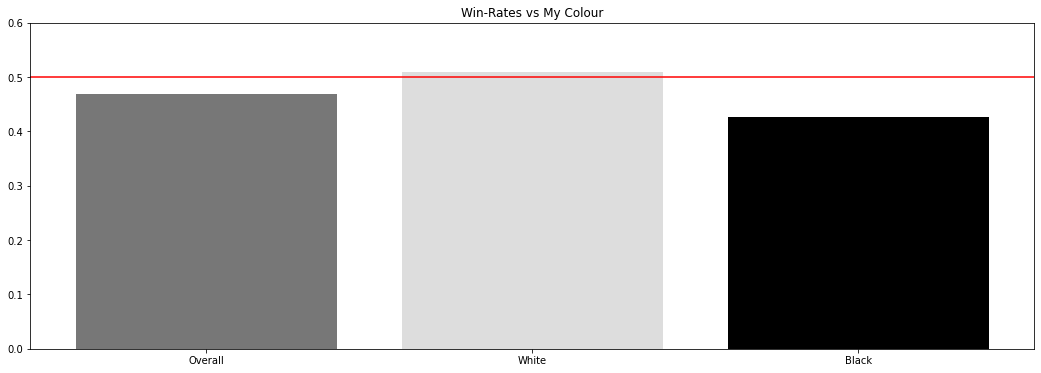

In [29]:
win_rates=[n_wins/n_games,n_white_wins/n_white_games,n_black_wins/n_black_games]
plt.bar(x=[0,1,2],height=win_rates,width=.8,tick_label=["Overall","White","Black"],color=["#777","#ddd","#000"])
plt.ylim(0,.6)
plt.axhline(.5,c="red")
plt.title("Win-Rates vs My Colour")

# Cummulative Win Rate

In [30]:
def calc_cum_wins_losses(df) -> (pd.Series,pd.Series):
    cum_wins=(df["my_outcome"]=="win").cumsum()
    cum_wins=cum_wins.reset_index(drop=True)
    cum_losses=pd.Series(range(1,cum_wins.shape[0]+1))-cum_wins
    return cum_wins,cum_losses

In [31]:
# all games
cum_wins_all,cum_losses_all=calc_cum_wins_losses(df)

# white games
cum_wins_white,cum_losses_white=calc_cum_wins_losses(df[df["my_colour"]=="white"])

# white games
cum_wins_black,cum_losses_black=calc_cum_wins_losses(df[df["my_colour"]=="black"])

In [32]:
# plot cumulative wins and losses against games
def plot_cum_wins_losses(ax,wins,losses,legend=False,title=None,colour=None):
    # plot data
    ax.plot(wins,c="green",label="Wins")
    ax.plot(losses,c="red",label="Losses")
    
    # text
    if legend: ax.legend()
    if title: ax.set_title(title)
    ax.set_xlabel("Games Played")
    ax.set_ylabel("Count")

    # plot line to show net 0
    ax.plot(range(len(wins)),np.linspace(start=0,stop=np.ceil(len(wins)/2),num=len(wins)),c="black")
    
    # emphasise difference
    ax.fill_between(x=range(len(wins)),y1=wins,y2=losses, where=(wins<=losses),interpolate=True,color='red',alpha=.2)
    ax.fill_between(x=range(len(wins)),y1=wins,y2=losses, where=(wins>=losses),interpolate=True,color='green',alpha=.2)
    
    # style axes
    ax.margins(0)
    ax.grid()

In [33]:
# plot net cumulative wins and losses against games
def plot_net_cum_wins_losses(ax,wins,losses,legend=False,title=None,colour=None):
    # calculate net
    net=wins-losses
    
    # split data into positive,negative and 0
    pos=np.ma.masked_where(net<0,net)
    neg=np.ma.masked_where(net>0,net)
    non=np.ma.masked_where(net!=0,net)
    
    # plot data (pos=green etc.)
    ax.plot(pos,c="green")
    ax.plot(neg,c="red")
    ax.plot(non,c="gray")
    
    # emphasise difference
    ax.fill_between(x=range(len(net)),y1=net,y2=0, where=(net<=0),interpolate=True,color='red',alpha=.2)
    ax.fill_between(x=range(len(net)),y1=net,y2=0, where=(net>=0),interpolate=True,color='green',alpha=.2)
    
    # plot line to show net 0
    ax.axhline(y=0,c="black")
    
    # text
    if title: ax.set_title(title)
    ax.set_xlabel("Games Played")
    ax.set_ylabel("Net Count")
    
    # style axes
    ax.margins(0)
    ax.grid()
    
    # plot expected wins (white) expect losses (black)
    if colour=="white":
        upper_bound=(pd.Series(list(range(len(net))))*(exp_white_win_rate[1]-.5)).tolist()
        lower_bound=(pd.Series(list(range(len(net))))*(exp_white_win_rate[0]-.5)).tolist()
        ax.fill_between(x=list(range(len(net))),y1=upper_bound,y2=lower_bound,interpolate=True,color="green",alpha=.1,label="Exp. Wins")
    elif colour=="black":
        upper_bound=(pd.Series(list(range(len(net))))*(exp_black_win_rate[1]-.5)).tolist()
        lower_bound=(pd.Series(list(range(len(net))))*(exp_black_win_rate[0]-.5)).tolist()
        ax.fill_between(x=list(range(len(net))),y1=upper_bound,y2=lower_bound,interpolate=True,color="red",alpha=.1,label="Exp. Losses")
        
    if legend:
        ax.legend()

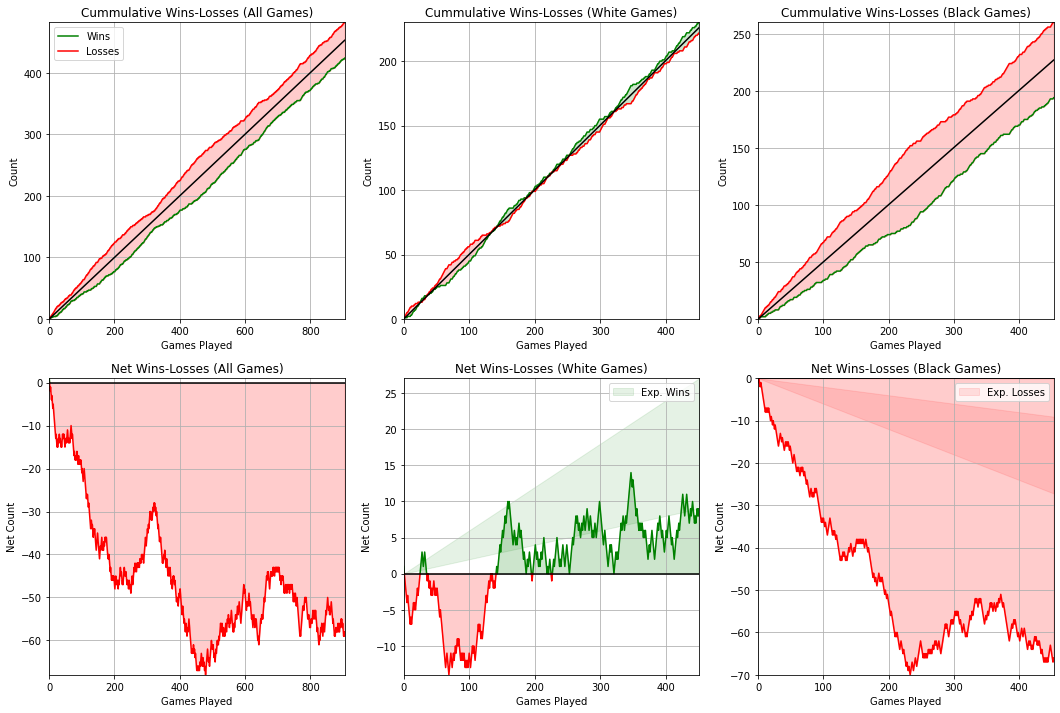

In [34]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(18,12))

plot_cum_wins_losses(ax[0,0],cum_wins_all,cum_losses_all,legend=True,title="Cummulative Wins-Losses (All Games)")
plot_cum_wins_losses(ax[0,1],cum_wins_white,cum_losses_white,title="Cummulative Wins-Losses (White Games)")
plot_cum_wins_losses(ax[0,2],cum_wins_black,cum_losses_black,title="Cummulative Wins-Losses (Black Games)")

plot_net_cum_wins_losses(ax[1,0],cum_wins_all,cum_losses_all,legend=False,title="Net Wins-Losses (All Games)")
plot_net_cum_wins_losses(ax[1,1],cum_wins_white,cum_losses_white,legend=True,title="Net Wins-Losses (White Games)",colour="white")
plot_net_cum_wins_losses(ax[1,2],cum_wins_black,cum_losses_black,legend=True,title="Net Wins-Losses (Black Games)",colour="black")

Basically, I am shite at playing as black and bang average (slightly below average) at white.

# Rolling Win Rate

In [35]:
# calculate rolling wind percentage of the last `trailing n` games
def calc_rolling_win_pct(cum_wins,trailing_n=100,include_start=True) -> pd.Series:
    blanks=pd.Series([0]*trailing_n)
    
    # calc rolling wins
    shifted_wins=blanks.append(cum_wins).reset_index(drop=True)
    extended_wins=cum_wins.append(blanks).reset_index(drop=True)
    rolling_wins=(extended_wins-shifted_wins)[:len(cum_wins)]
    
    # num_to_divide by
    divisors=list(range(1,min(trailing_n,len(cum_wins))))+([trailing_n]*max(0,len(cum_wins)-trailing_n+1))
    divisors=pd.Series(divisors)
    
    if include_start: return rolling_wins/divisors
    else: return (rolling_wins[trailing_n:]/trailing_n)

In [36]:
def plot_rolling_win_pct(ax,rolling_data,trailing_n=None,include_legend=False,title=None,colour=None):
    """
    PARAMS
    rolling_data - data from `calc_rolling_win_pct()`
    colour - colour of player in games (None,"white","black"). Used to plot expected win rates
    """
    xs=rolling_data.index
    
    # split data into positive,negative and 0
    pos=np.ma.masked_where(rolling_data<.5,rolling_data)
    neg=np.ma.masked_where(rolling_data>.5,rolling_data)
    non=np.ma.masked_where(rolling_data!=.5,rolling_data)
    
    # plot data (pos=green etc.)
    ax.plot(xs,pos,c="green")
    ax.plot(xs,neg,c="red")
    ax.plot(xs,non,c="gray")
    
    # plot neutral win rate & full-roll point
    ax.axhline(y=.5,c="black",ls="-")
    ax.axvline(x=trailing_n,c="black",ls="--")
    
    # emphasise difference
    ax.fill_between(x=xs,y1=rolling_data,y2=.5, where=(rolling_data<=.5),interpolate=True,color='red',alpha=.2)
    ax.fill_between(x=xs,y1=rolling_data,y2=.5, where=(rolling_data>=.5),interpolate=True,color='green',alpha=.2)
    
    # style axes
    ax.set_ylim(.3,.7)
    ax.margins(0)
    ax.grid()
    ax.set_xlabel("Games Played")
    ax.set_ylabel("Win Pct")
    
    # text
    if title:
        title_text=title
        if (trailing_n): title_text+=" for last {} game{}".format(trailing_n,"s" if trailing_n>1 else "")
        ax.set_title(title_text)
    
    # plot POIs
    if trailing_n:
        # plot min (after first `trailing_n` games)
        min_val=min(rolling_data.loc[trailing_n:,])
        min_xs=rolling_data[rolling_data==min_val].index.tolist()
        min_vals=[min_val]*len(min_xs)
        
        func_c=lambda x:"green" if x>.5 else ("gray" if x==.5 else "red")
        
        ax.scatter(min_xs,min_vals,marker="X",s=50,c=func_c(min_val),label="Min Value={:.2f}".format(min_val))
        
        # plot max (after first `trailing_n` games)
        max_val=max(rolling_data.loc[trailing_n:,])
        max_xs=rolling_data[rolling_data==max_val].index.tolist()
        max_vals=[max_val]*len(max_xs)
        
        ax.scatter(max_xs,max_vals,marker="X",s=100,c=func_c(max_val),label="Max Value={:.2f}".format(max_val))
    
    # plot expected win rates
    if (colour=="white"):
        ax.fill_between(x=xs,y1=exp_white_win_rate[0],y2=exp_white_win_rate[1],interpolate=True,color='blue',alpha=.2,label="Expected Win Rate")
    elif (colour=="black"):
        ax.fill_between(x=xs,y1=exp_black_win_rate[0],y2=exp_black_win_rate[1],interpolate=True,color='blue',alpha=.2,label="Expected Win Rate")
    
    # legend
    if include_legend: ax.legend()

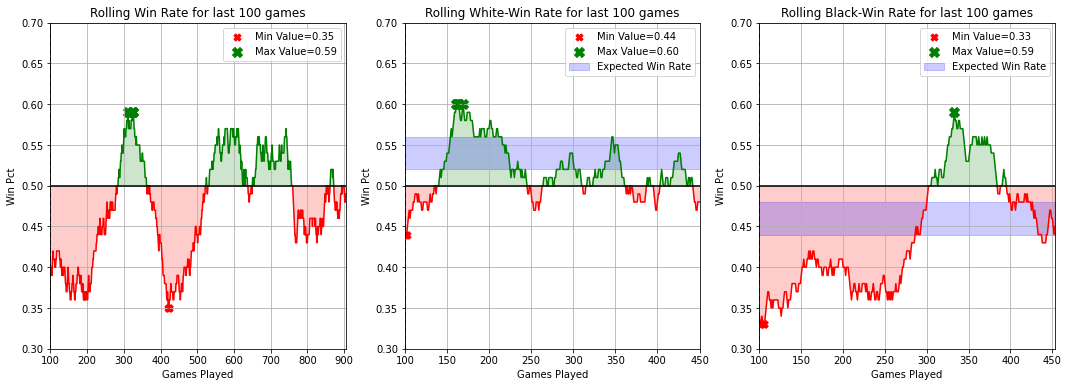

In [37]:
trailing_n=100

# calculate rolling win rates
rolling_wins=calc_rolling_win_pct(cum_wins_all,trailing_n=trailing_n,include_start=False)
rolling_white_wins=calc_rolling_win_pct(cum_wins_white,trailing_n=trailing_n,include_start=False)
rolling_black_wins=calc_rolling_win_pct(cum_wins_black,trailing_n=trailing_n,include_start=False)

# plot data
fig,ax=plt.subplots(nrows=1,ncols=3)
plot_rolling_win_pct(ax[0],rolling_wins,trailing_n=trailing_n,include_legend=True,title="Rolling Win Rate")
plot_rolling_win_pct(ax[1],rolling_white_wins,trailing_n=trailing_n,include_legend=True,colour="white",title="Rolling White-Win Rate")
plot_rolling_win_pct(ax[2],rolling_black_wins,trailing_n=trailing_n,include_legend=True,colour="black",title="Rolling Black-Win Rate")

In [38]:
def calc_time_with_given_win_rate(rolling_data,cond=lambda x:x>=.5) -> float:
    return rolling_data.apply(cond).sum()/rolling_data.shape[0]

In [39]:
pct_all=calc_time_with_given_win_rate(rolling_wins[trailing_n:],cond=lambda x:x>=.5)
pct_white=calc_time_with_given_win_rate(rolling_white_wins[trailing_n:],cond=lambda x:x>=.5)
pct_black=calc_time_with_given_win_rate(rolling_black_wins[trailing_n:],cond=lambda x:x>=.5)

print("After the first {} games, I had a positive rolling win rate {:.1f}% of the time.".format(trailing_n,pct_all*100))
print("After the first {} white games, I had a positive rolling white-win rate {:.1f}% of the time.".format(trailing_n,pct_white*100))
print("After the first {} black games, I had a positive rolling black-win rate {:.1f}% of the time.".format(trailing_n,pct_black*100))

After the first 100 games, I had a positive rolling win rate 47.3% of the time.
After the first 100 white games, I had a positive rolling white-win rate 78.6% of the time.
After the first 100 black games, I had a positive rolling black-win rate 35.8% of the time.


In [40]:
pct_exp_or_better_white=calc_time_with_given_win_rate(rolling_white_wins[trailing_n:],cond=lambda x:x>=exp_white_win_rate[0])
pct_exp_or_better_black=calc_time_with_given_win_rate(rolling_black_wins[trailing_n:],cond=lambda x:x>=exp_black_win_rate[0])

print("After the first {} white games, I attained the minimum expected white-win rate ({:.0f}%) {:.1f}% of the time.".format(trailing_n,100*exp_white_win_rate[0],100*pct_exp_or_better_white))
print("After the first {} black games, I attained the minimum expected black-win rate ({:.0f}%) {:.1f}% of the time.".format(trailing_n,100*exp_black_win_rate[0],100*pct_exp_or_better_black))

After the first 100 white games, I attained the minimum expected white-win rate (52%) 42.9% of the time.
After the first 100 black games, I attained the minimum expected black-win rate (44%) 64.2% of the time.


# Outcomes
This is not accounting for the ELOs of my opponents, only the order in which games occurred.

In [41]:
# reason for win
reasons_i_win=df[df["my_outcome"]=="win"]["opponent_result"].value_counts(normalize=True)

# reason for loss
reasons_i_lose=df[df["my_outcome"]=="loss"]["my_result"].value_counts(normalize=True)

merged_reasons=pd.DataFrame({"win":reasons_i_win,"loss":reasons_i_lose})

<AxesSubplot:>

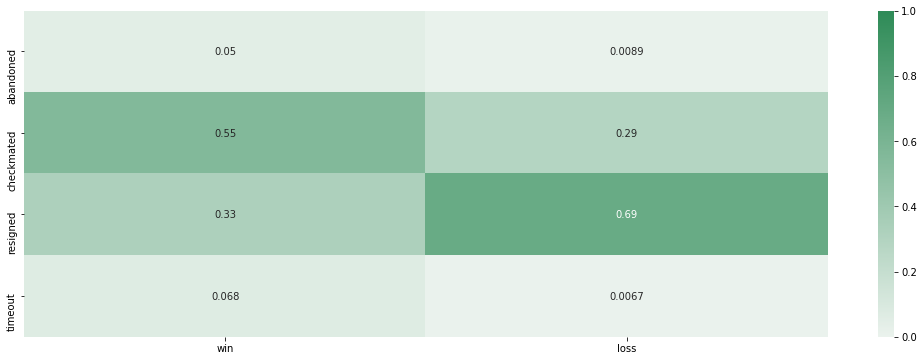

In [42]:
cmap_green=sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(merged_reasons,annot=True,cmap=cmap_green,vmin=0,vmax=1)

I conceed to opponents a lot more often (69% vs 33%) than opponents conceed to me. Maybe this is a suggestion that I need to stick games out more (or I get myself into "bad" scenarios quicker than my opponent).

In [43]:
def calc_rolling_occurence_pct(vals:pd.Series,target,trailing_n=100,include_start=True) -> pd.Series:
    cum_occ=(vals==target).cumsum()
    
    # calc rolling wins
    blanks=pd.Series([0]*trailing_n)
    shifted=blanks.append(cum_occ).reset_index(drop=True)
    extended=cum_occ.append(blanks).reset_index(drop=True)
    rolling=(extended-shifted)[:len(cum_occ)]
    
    # num_to_divide by
    divisors=list(range(1,min(trailing_n,len(cum_occ))))+([trailing_n]*max(0,len(cum_occ)-trailing_n+1))
    divisors=pd.Series(divisors)
    
    if include_start: return rolling/divisors
    else: return (rolling[trailing_n:]/trailing_n)

In [44]:
def calc_all_rolling_occurence_pct(vals:pd.Series,trailing_n=100,include_start=True) -> pd.DataFrame:
    df=pd.DataFrame()
    for res in sorted(vals.unique()):
        df[res]=calc_rolling_occurence_pct(vals,target=res,trailing_n=trailing_n,include_start=include_start)
    return df

In [45]:
def plot_all_rolling_occurence_pct(ax,df:pd.DataFrame,trailing_n=None,title=None):
    df.plot(kind="line",ax=ax)
    ax.margins(0)
    ax.legend()
    ax.set_ylim(0,1)
    ax.set_ylabel("Outcome Occurence pct")
    ax.set_xlabel("Games Played")
    
    title_text=title if title else "Rolling occurence rate of outcomes"
    
    if trailing_n:
        ax.axvline(x=trailing_n,ls="--",c="black",label="")
        title_text+=" for last {} games".format(trailing_n)
        
    ax.set_title(title_text)

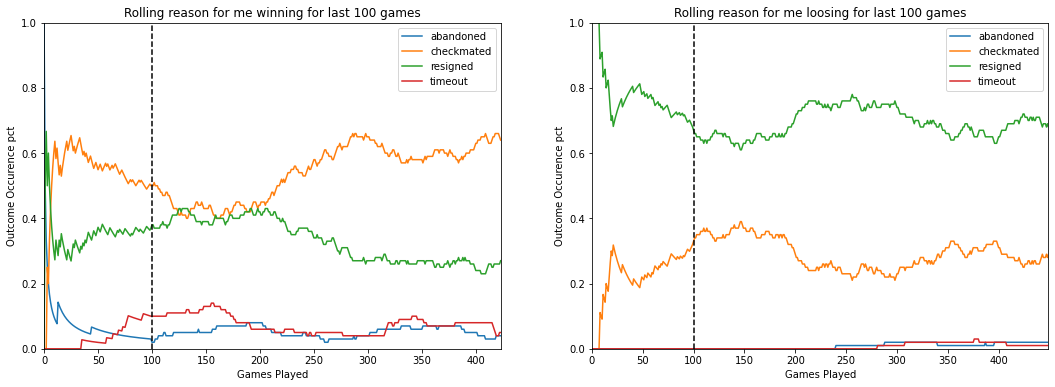

In [46]:
trailing_n=100

# reasons i win
opp_results=df[df["my_outcome"]=="win"]["opponent_result"]
rolling_results_win=calc_all_rolling_occurence_pct(opp_results,trailing_n=trailing_n,include_start=True)

# reasons i loose
my_results=df[df["my_outcome"]=="loss"]["my_result"]
rolling_results_lose=calc_all_rolling_occurence_pct(my_results,trailing_n=trailing_n,include_start=True)

fig,ax=plt.subplots(nrows=1,ncols=2)
plot_all_rolling_occurence_pct(ax[0],rolling_results_win,trailing_n=trailing_n,title="Rolling reason for me winning")
plot_all_rolling_occurence_pct(ax[1],rolling_results_lose,trailing_n=trailing_n,title="Rolling reason for me loosing")

I have always resigned more often than my opponents. I am now forcing more checkmates than before, although the minimum number of checkmates coincides with the maximum in timeouts (These timeouts are likely games where I would manage a checkmate eventually). I timeout significantly less often than my opponents.

# Game Details
 * Match Length
 * Move count
 * Win pct vs move count (maybe only look at checkmates as it means match has taken full course).

In [47]:
total_time=df["match_length"].sum()
total_moves=df[df["match_length"].notnull()]["num_moves"].sum()
avg_time=total_time/total_moves
print("Avg. time per move = {:.1f}s".format(avg_time))

Avg. time per move = 10.5s


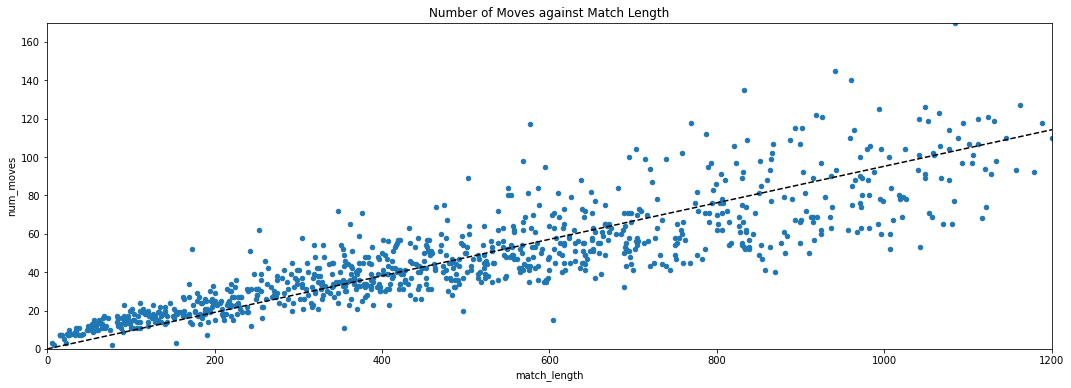

In [48]:
df.plot(kind="scatter",x="match_length",y="num_moves")
plt.margins(0)
plt.xlim(0,1200)
plt.ylim()
plt.title("Number of Moves against Match Length")

ys=list(range(int(plt.gca().get_ylim()[1])))
xs=[y*avg_time for y in ys]
plt.plot(xs,ys,c="black",ls="--")

# TODO - calculate num_white_moves & num_black_moves

In [116]:
# histogram of match length grouped into `interval_length` seconds
interval_length=30
count,divisions=np.histogram(df["match_length"],bins=range(0,1201,interval_length),normed=True)

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


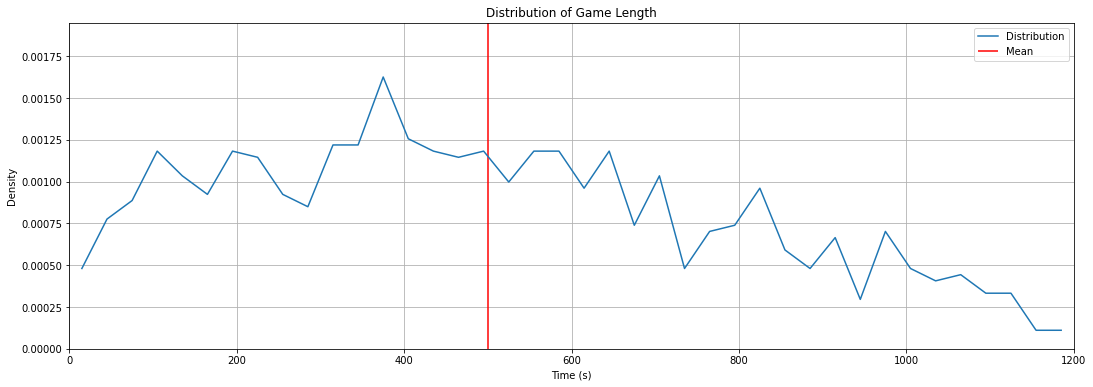

In [117]:
midpoints=(1/2)*(divisions[:-1]+divisions[1:])
plt.plot(midpoints,count,label="Distribution")
plt.title("Distribution of Game Length")
plt.xlabel("Time (s)")
plt.ylabel("Density")
plt.margins(0)
plt.grid()
plt.ylim([0,6*(plt.gca().get_ylim()[1])/5])
plt.xlim([0,1200])
plt.vlines(x=df["match_length"].mean(),ymin=0,ymax=1,color="red",label="Mean")
plt.legend()

# Pieces Used

 * Number of moves per piece.
 * Takes per piece (after n turns; across whole game)
 * Heatmap for piece position (after n turns; across whole game)

# ELO

 * My rating
 * Average rating beaten/lost to (rolling over time)

# Dates

* Day with most games/losses/wins
* Day with greatest win-rate.
* By DoW.
* Days since last game.
* Win-rate as a function of time since last game.

# Time
 * Win-rate at different times of day